In [2]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Loading images from data
# WIN path
#PATH = "C:/Users/Lenovo/Desktop/AI/AI_Project/data/"
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/data_4500/"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('*/*/*.jpg')))
image_csv = pd.read_csv(PATH+'RAW_DATA_4500_6_class.csv')
CLASS_NAME = image_csv['Finding Labels'].unique()
print(image_num)
print(CLASS_NAME)

22648
['No Finding' 'TB' 'Heart' 'CA Lung' 'Intra' 'Extra']


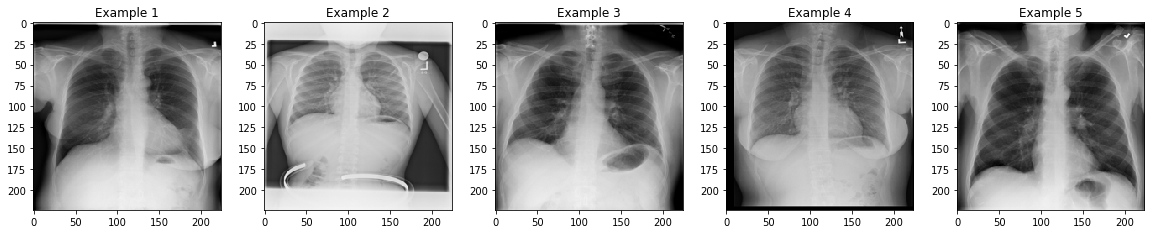

In [4]:
example_NoF = list(data_dir.glob('train/No Finding/*.jpg'))
i = 1
plt.figure(figsize=(20,20))
for n in example_NoF[:5]:
    ex = Image.open(n)
    ex_ar = np.asarray(ex)
    plt.subplot(5,5,i)
    word = "Example "+ str(i)
    plt.title(word)
    plt.imshow(ex_ar)
    i+=1

In [5]:
#Preproccsing image data into ImageDataGenerator
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "/train/"
TEST_PATH = PATH + "/test/"

#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME))
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME))

x_train,y_train = next(data_gen_train)
x_test,y_test = next(data_gen_test)
TRAIN_IMG = 18118
TEST_IMG = 4530

Found 18118 images belonging to 6 classes.
Found 4530 images belonging to 6 classes.


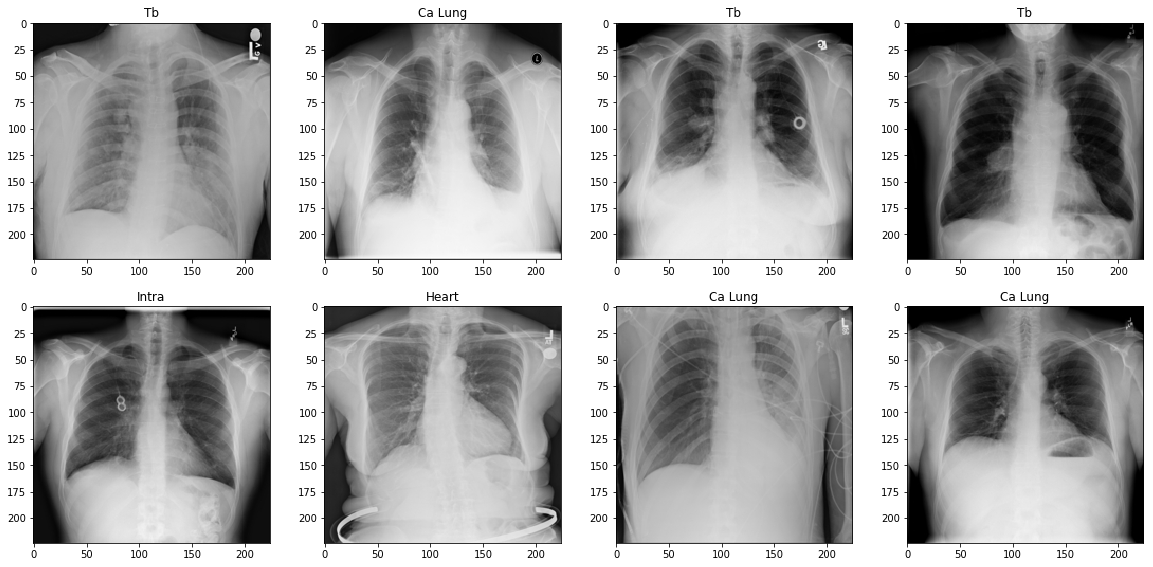

In [6]:
plt.figure(figsize=(20,20))
for n in range(8):
    plt.subplot(4,4,n+1)
    plt.title(CLASS_NAME[y_train[n]==1][0].title())
    plt.imshow(x_train[n])

In [7]:
#Try to load InceptionV3
# myInception = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet',
#                                                 input_shape=(224,224,3),
#                                                 classes=6)
# for layer in myInception.layers:
#     layer.trainable = False

In [9]:
#Try to load vgg19
myInception = tf.keras.applications.VGG19(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224,224,3),
                                                classes=6)
for layer in myInception.layers:
    layer.trainable = False

In [10]:
#Add layers configuration suitable for our model
#This is THE endgame for our project . Carefully review your stradigies 
# Current layers stacking is Awful . Inaccurate with fake accuracy

out = myInception.output
out = layers.GlobalAveragePooling2D()(out)
#out = layers.Dense(1024,activation='relu')(out)
#out = layers.Dense(512,activation='relu')(out)
#out = layers.Dense(64,activation='relu')(out)
out = layers.Dropout(0.5)(out)
out = layers.Dense(6,activation='sigmoid')(out)

myModel = Model(myInception.input,out)

In [25]:
#myModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
myEarly = EarlyStopping(monitor='val_loss',patience=50,verbose=1)
myCheckpoint = ModelCheckpoint('myModel_Check_VGG19.hdf5',monitor='val_loss')
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.99 or log.get('loss') < 0.01):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()


In [13]:
myModel.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(lr=1e-4)
                ,metrics=['accuracy',metrics.AUC()])

In [17]:
#Try to fit data into our model
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
session = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_test,
                               epochs = 30,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = 30,
                               verbose = 1,
                               callbacks=[myEarly,myCheckpoint,myStop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 567.0 steps, validate for 30 steps
Epoch 1/30
567/567 [==============================] - 111s 195ms/step - loss: 1.6488 - accuracy: 0.2090 - auc: 0.6062 - val_loss: 1.6377 - val_accuracy: 0.2323 - val_auc: 0.6456
Epoch 2/30
567/567 [==============================] - 110s 193ms/step - loss: 1.6399 - accuracy: 0.2072 - auc: 0.6125 - val_loss: 1.6363 - val_accuracy: 0.2198 - val_auc: 0.6440
Epoch 3/30
567/567 [==============================] - 109s 193ms/step - loss: 1.6352 - accuracy: 0.2249 - auc: 0.6212 - val_loss: 1.6340 - val_accuracy: 0.2583 - val_auc: 0.6553
Epoch 4/30
567/567 [==============================] - 109s 193ms/step - loss: 1.6294 - accuracy: 0.2318 - auc: 0.6305 - val_loss: 1.6319 - val_accuracy: 0.2615 - val_auc: 0.6549
Epoch 5/30
567/567 [==============================] - 109s 193ms/step - loss: 1.6252 - accuracy: 0.2412 - auc: 0.6379 - val_loss: 1.6290 - val_accuracy: 0.2667 - val_auc: 0.6591
Epoch 6/30
567/

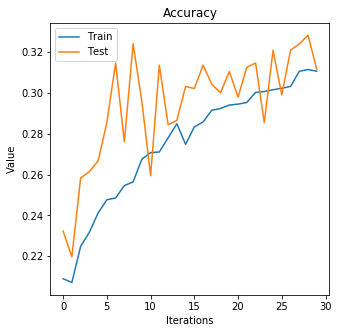

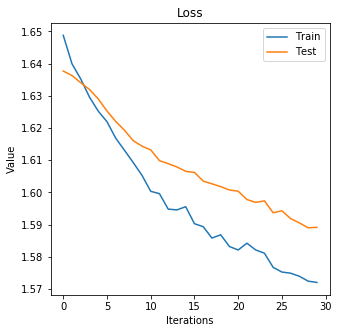

In [18]:
plt.figure(figsize=(5,5))
plt.plot(session.history['accuracy'])
plt.plot(session.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Test'])
plt.savefig("VGG_Run_Accuracy.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(session.history['loss'])
plt.plot(session.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Test'])
plt.savefig("VGG_Run_Loss.png")
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix,f1_score
y_res = myModel.predict(x_test)
y_pred = np.argmax(y_res,axis=1)
y_true = np.argmax(y_test,axis=1)
myCM = confusion_matrix(y_true,y_pred)
myCM_Nor = myCM.astype('float')/myCM.sum(axis=1)[:,np.newaxis]
print(myCM)
print(myCM_Nor)

[[4 0 0 0 2 0]
 [1 1 2 0 1 0]
 [1 0 1 0 2 0]
 [4 0 3 0 5 0]
 [0 0 1 0 3 0]
 [0 0 1 0 0 0]]
[[0.66666667 0.         0.         0.         0.33333333 0.        ]
 [0.2        0.2        0.4        0.         0.2        0.        ]
 [0.25       0.         0.25       0.         0.5        0.        ]
 [0.33333333 0.         0.25       0.         0.41666667 0.        ]
 [0.         0.         0.25       0.         0.75       0.        ]
 [0.         0.         1.         0.         0.         0.        ]]


In [91]:
#7th run CM is lost one class !!!WTF
y_test.shape

(32, 6)

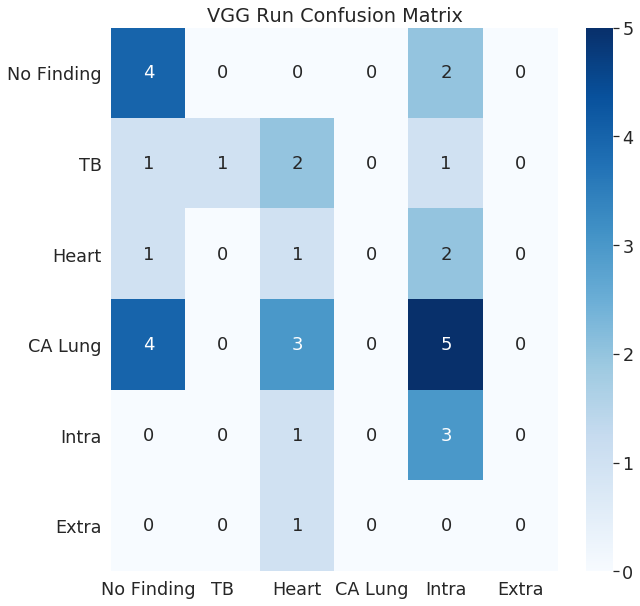

In [21]:
import seaborn as sn
import pandas as pd

cm_plot = pd.DataFrame(myCM,CLASS_NAME,CLASS_NAME)
sn.set(font_scale=1.6)
plt.figure(figsize=(10,10))
plt.title("VGG Run Confusion Matrix")
cm= sn.heatmap(cm_plot,annot=True,annot_kws={"size":18},cmap="Blues")
cm = cm.get_figure()
cm.savefig('VGG_run_CM.png')
plt.show()

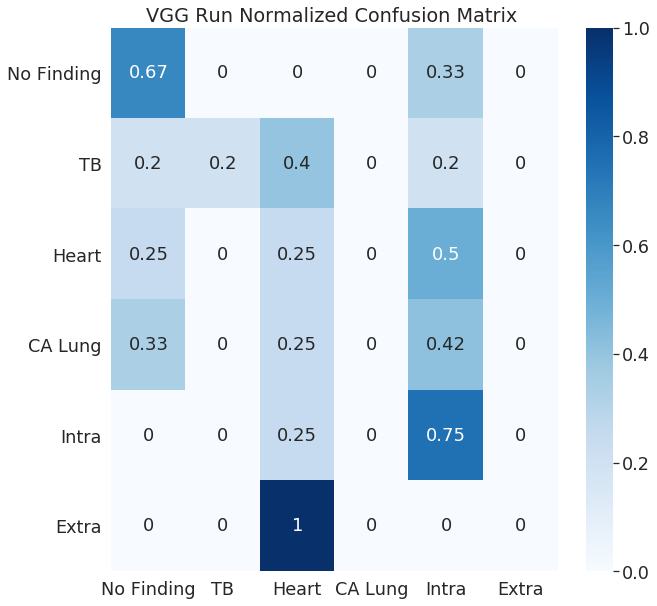

In [22]:
cm_plot = pd.DataFrame(myCM_Nor,CLASS_NAME,CLASS_NAME)
sn.set(font_scale=1.6)
plt.figure(figsize=(10,10))
plt.title("VGG Run Normalized Confusion Matrix ")
cm= sn.heatmap(cm_plot,annot=True,annot_kws={"size":18},cmap="Blues")
cm = cm.get_figure()
cm.savefig('VGG_run_CM_nor.png')
plt.show()

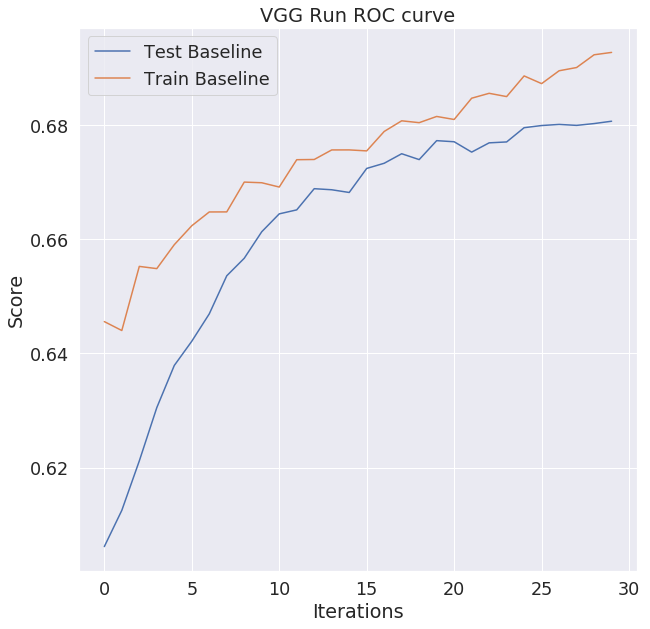

In [24]:
plt.figure(figsize=(10,10))
plt.plot(session.history['auc'])
plt.plot(session.history['val_auc'])
plt.title("VGG Run ROC curve")
plt.legend({'Train Baseline','Test Baseline'})
plt.ylabel('Score')
plt.xlabel('Iterations')
plt.savefig("VGG_Run_ROC.png")
plt.show()